In [1]:
#%reset -f
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PolyCollection #for plots polygons as rasters
import xarray as xr
from datetime import datetime, timedelta as delta
from matplotlib import path
from scipy.spatial import KDTree, cKDTree #c implementation is faster (to find nearest neighbor)
import os
import dask as da
from tqdm import tqdm
import glob
from scipy.interpolate import griddata #interpolation in space for non-uniform grids

In [12]:
#inputs----------
#path of directories
homee = "/export/lv4/user/jfajardourbina/"
dir_vel= f"{homee}dws_ulf_getm_2D_depth_avg/data/velocity/"
savee='everyM2' #saving track data every m2
deploy='everyM2'#deploy set of particles every m2
minTsim=60 #mimimum time of simulation (days)
maxTsim=91 #maximum time of simulation (days)
dir_tracks = f"{homee}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/exp-deployHighVolume_coords-xcyc_save-{savee}_deploy-{deploy}_Tsim-{minTsim}-{maxTsim}d/tracks/"
dir_dws_bound = f"{homee}dws_ulf_getm_2D_depth_avg/experiments_post_proc/analysis_eulerian_data_36years/data_dws_boundaries/"
#files
files_vel_root="RE.DWS200m.uvz."
file_dws_bound0="dws_boundaries_contour0.nc"; #contour of DWS are the land points closest to ocean points
file_dws_bound0p5="dws_boundaries_contour0p5.nc"
#parameters
npa_per_dep=12967 #number of particles per deployment
m2=int(12.42*3600+2) #period in seconds
dx=400/1e3; dy=400/1e3 #particle grid resolution

In [7]:
#open dws boundaries----
names_tr=["marsdiep","eierlandsgat","vlie","borndiep","pinkegat","watershed1"]
names_islands=["coast","texel","vlieland","terschelling","ameland","schiermonnikoog"]
#contour0 (inlets and boundaries along coast and islands)
dsb0=xr.open_dataset(dir_dws_bound+file_dws_bound0) #float64
bdr_dws0=dsb0.bdr_dws.values #points that define DWS
#contour0p5 (inlets and boundaries defined approx 100m from the points along the coast)
dsb0p5=xr.open_dataset(dir_dws_bound+file_dws_bound0p5) 
bdr_dws0p5=dsb0p5.bdr_dws.values #points that define DWS

In [9]:
#open velocity file---
year_sim=2009;month_sim=5
file_vel_path=f"{dir_vel}{files_vel_root}{year_sim}{month_sim:02d}01.nc" #:02d includes leading zeros (at the begin)
ds=xr.open_dataset(file_vel_path,chunks={'xc':-1,'yc':-1,'time':110}) #chunks every 36h
xc=ds.xc; yc=ds.yc; h=ds.bathymetry.load()
mask=h.copy(); mask=xr.where(np.isfinite(mask),1,0) #mask ocean=1, land=0

### Net displacement every M2 for 2009-05

In [5]:
year_sim=2009; month_sim=5

#open particle trajectories---
file_track=f'tracks_{year_sim}{month_sim:02d}_coords-xcyc_save-{savee}_deploy-{deploy}_Tsim-{minTsim}-{maxTsim}d.nc'
file_track_path=f'{dir_tracks}{year_sim}/{file_track}'  
dst=xr.open_dataset(file_track_path, chunks={'traj': npa_per_dep}) #float32, a bit faster than npa_per_dep*10 when .compute data for this case
dst.close()
#get number of deployments for this month
num_deploys_1m=int(dict(dst.dims)['traj']/npa_per_dep)
num_deploys_1m

60

/tmp/ipykernel_121026/3949293328.py:14: UserWarning: No contour levels were found within the data range.
  ax.contour(xc/1e3,yc/1e3,mask,[1],colors='k',linewidths=1,zorder=3);


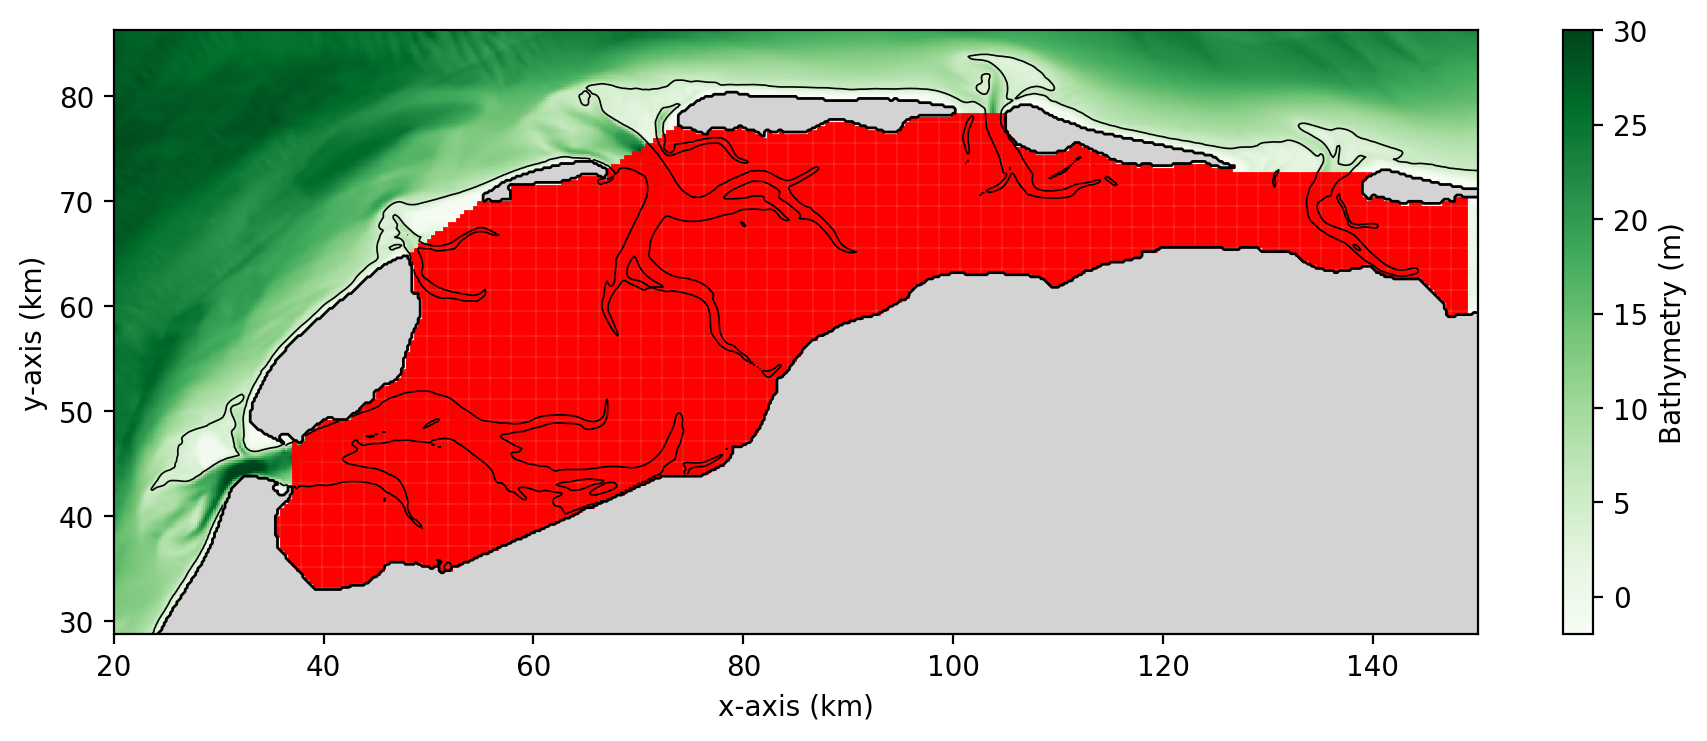

In [6]:
#initial position of particles-----

#plot---
fig,ax= plt.subplots(1,1,figsize=(11,4), dpi=200)
#
#background map
cmap = mpl.cm.get_cmap("Greens").copy()
cmap.set_bad(color='lightgrey')
aa=ax.pcolormesh(xc/1e3,yc/1e3,h,vmin=-2,vmax=30,shading='auto',cmap=cmap)#wind-energy lon-lat
cbar=plt.colorbar(aa,ax=ax); cbar.ax.set_ylabel('Bathymetry (m)')
ax.set_xlabel('x-axis (km)'); ax.set_ylabel('y-axis (km)')
ax.axis('equal'); ax.axis([20,150,30,85]);
ax.contour(xc/1e3,yc/1e3,h,[5],colors='k',linewidths=.6,zorder=3) #bathy in lon-lat from topo file 
ax.contour(xc/1e3,yc/1e3,mask,[1],colors='k',linewidths=1,zorder=3);
#
#plot initial positions of particles
ax.plot(dst.x.isel(traj=range(npa_per_dep),obs=0)/1e3,dst.y.isel(traj=range(npa_per_dep),obs=0)/1e3,'sr',ms=1,zorder=2)
#

In [6]:
x0=dst.x.isel(traj=range(npa_per_dep),obs=0).values; y0=dst.y.isel(traj=range(npa_per_dep),obs=0)
pxy0=np.c_[x0,y0]/1e3
polys0=[]
for i in range(pxy0.shape[0]):
    jj=np.array([[pxy0[i,0]-dx/2,pxy0[i,1]-dy/2], [pxy0[i,0]+dx/2,pxy0[i,1]-dy/2],
                 [pxy0[i,0]+dx/2,pxy0[i,1]+dy/2], [pxy0[i,0]-dx/2,pxy0[i,1]+dy/2]])
    polys0.append(jj) #4 coordinates of a square

In [8]:
#for the 1st deployment select the 1st displacement----

dep=0 #1st deployment
it=0 #1st displacement
#
#net displacement
dxx=dst.x.isel(traj=np.arange(npa_per_dep)+npa_per_dep*dep,obs=range(10)).diff("obs")/1e3
dyy=dst.y.isel(traj=np.arange(npa_per_dep)+npa_per_dep*dep,obs=range(10)).diff("obs")/1e3
#
#initial time of the above deployment, and next time
t0=str(dst.time.isel(obs=0+it,traj=npa_per_dep*dep).values)[:-10]
t1=str(dst.time.isel(obs=0+it+1,traj=npa_per_dep*dep).values)[:-10]

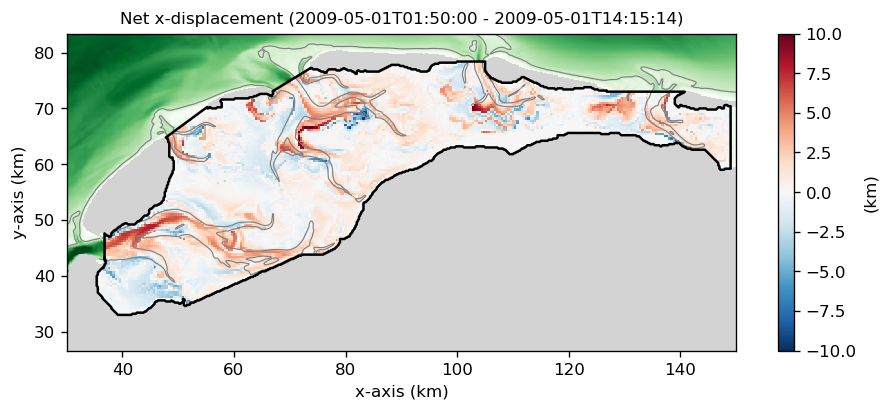

In [9]:
#dxx-----
val=dxx.isel(obs=it).values 
#
fig,ax=plt.subplots(1,1,figsize=(9,3.5),dpi=120)
#background map
cmap = mpl.cm.get_cmap("Greens").copy()
cmap.set_bad(color='lightgrey')
aa=ax.pcolormesh(xc/1e3,yc/1e3,h,vmin=-2,vmax=30,shading='auto',cmap=cmap)#wind-energy lon-lat
ax.set_xlabel('x-axis (km)'); ax.set_ylabel('y-axis (km)')
ax.plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'-k',lw=1.5)
ax.contour(xc/1e3,yc/1e3,h,[5],colors='grey',linewidths=.7)
pc = PolyCollection(polys0,cmap='RdBu_r') 
val = np.ma.array(val, mask=np.isnan(val)) #mask because array idtrmout has nan values
pc.set_array(val);pc.set_clim([-10,10])
ax.add_collection(pc); cbar=plt.colorbar(pc,ax=ax); cbar.ax.set_ylabel("(km)")
ax.plot()
ax.axis('equal');ax.axis([30,150,30,80]);
ax.set_title(f'Net x-displacement ({t0} - {t1})',fontsize=10);

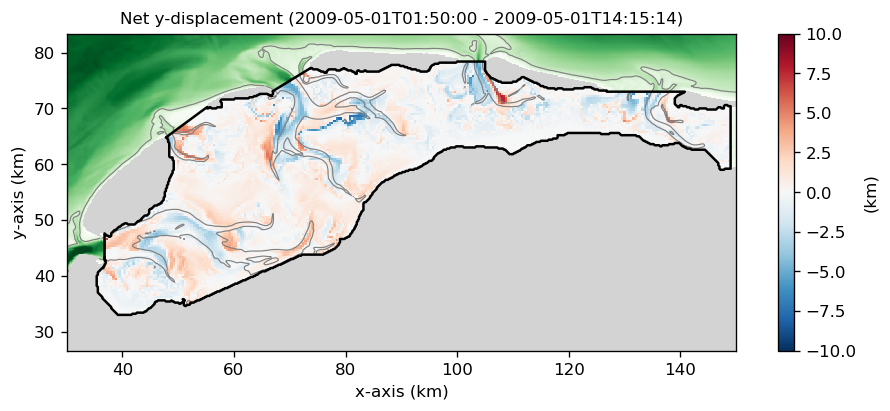

In [10]:
#dyy-----
val=dyy.isel(obs=it).values 
#
fig,ax=plt.subplots(1,1,figsize=(9,3.5),dpi=120)
#background map
cmap = mpl.cm.get_cmap("Greens").copy()
cmap.set_bad(color='lightgrey')
aa=ax.pcolormesh(xc/1e3,yc/1e3,h,vmin=-2,vmax=30,shading='auto',cmap=cmap)#wind-energy lon-lat
ax.set_xlabel('x-axis (km)'); ax.set_ylabel('y-axis (km)')
ax.plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'-k',lw=1.5)
ax.contour(xc/1e3,yc/1e3,h,[5],colors='grey',linewidths=.7)
pc = PolyCollection(polys0,cmap='RdBu_r') 
val = np.ma.array(val, mask=np.isnan(val)) #mask because array idtrmout has nan values
pc.set_array(val);pc.set_clim([-10,10])
ax.add_collection(pc); cbar=plt.colorbar(pc,ax=ax); cbar.ax.set_ylabel("(km)")
ax.plot()
ax.axis('equal');ax.axis([30,150,30,80]);
ax.set_title(f'Net y-displacement ({t0} - {t1})',fontsize=10);

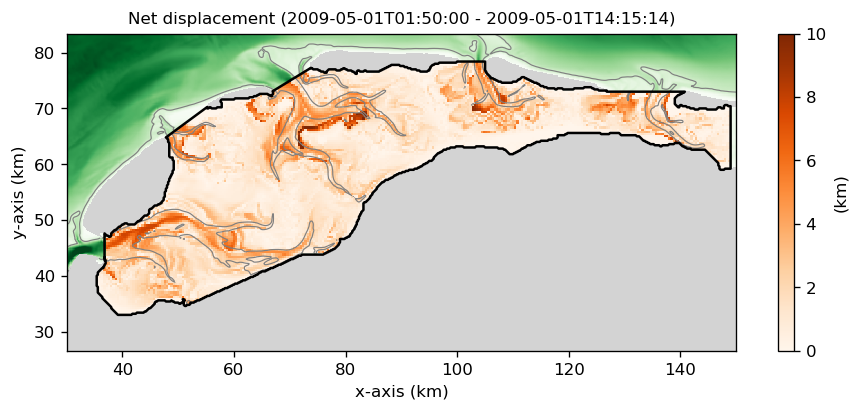

In [11]:
#(dxx**2+dyy**2)**.5-----
val=(dxx.isel(obs=it).values**2+dyy.isel(obs=it).values**2)**.5
#
fig,ax=plt.subplots(1,1,figsize=(9,3.5),dpi=120)
#background map
cmap = mpl.cm.get_cmap("Greens").copy()
cmap.set_bad(color='lightgrey')
aa=ax.pcolormesh(xc/1e3,yc/1e3,h,vmin=-2,vmax=30,shading='auto',cmap=cmap)#wind-energy lon-lat
ax.set_xlabel('x-axis (km)'); ax.set_ylabel('y-axis (km)')
ax.plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'-k',lw=1.5)
ax.contour(xc/1e3,yc/1e3,h,[5],colors='grey',linewidths=.7)
pc = PolyCollection(polys0,cmap='Oranges') 
val = np.ma.array(val, mask=np.isnan(val)) #mask because array idtrmout has nan values
pc.set_array(val);pc.set_clim([0,10])
ax.add_collection(pc); cbar=plt.colorbar(pc,ax=ax); cbar.ax.set_ylabel("(km)")
ax.plot()
ax.axis('equal');ax.axis([30,150,30,80]);
ax.set_title(f'Net displacement ({t0} - {t1})',fontsize=10);

In [7]:
#gridding data with nearest neighbor, so we can use quiver
def gridding(var,x0,y0):
    xmin=x0.min();xmax=x0.max();ymin=y0.min();ymax=y0.max()
    xgrid=np.arange(xmin-dx*1e3,xmax+2*dx*1e3,dx*1e3)
    ygrid=np.arange(ymin-dy*1e3,ymax+2*dy*1e3,dy*1e3)
    xgrid0,ygrid0=np.meshgrid(xgrid,ygrid)
    valgrid=xgrid0.flatten()*np.nan
    tree = cKDTree(np.c_[xgrid0.flatten(),ygrid0.flatten()]) #points in the new extended grid
    _,ij = tree.query(np.c_[x0,y0], k=1) #get index for every x0,y0 to put values in the new grid
    valgrid[ij]=var
    valgrid=np.reshape(valgrid,(len(ygrid),len(xgrid)))
    return xgrid0,ygrid0,valgrid

In [8]:
#gridding data with nearest neighbor in a extended domain (to avoid problems in boundaries when using convolution)
def gridding2(var,x0,y0):
    xmin=x0.min();xmax=x0.max();ymin=y0.min();ymax=y0.max()
    extend_grid=10 #so from particle min max positions extend grid 10*dx (to not have problems with convolution)
    xgrid=np.arange(xmin-dx*1e3*extend_grid,xmax+dx*1e3*(extend_grid+1),dx*1e3)
    ygrid=np.arange(ymin-dy*1e3*extend_grid,ymax+dy*1e3*(extend_grid+1),dy*1e3)
    xgrid0,ygrid0=np.meshgrid(xgrid,ygrid)
    valgrid=xgrid0.flatten()*np.nan
    tree = cKDTree(np.c_[xgrid0.flatten(),ygrid0.flatten()]) #points in the new extended grid
    _,ij = tree.query(np.c_[x0,y0], k=1) #get index for every x0,y0 to put values in the new grid
    valgrid[ij]=var
    valgrid=np.reshape(valgrid,(len(ygrid),len(xgrid)))
    return xgrid0,ygrid0,valgrid

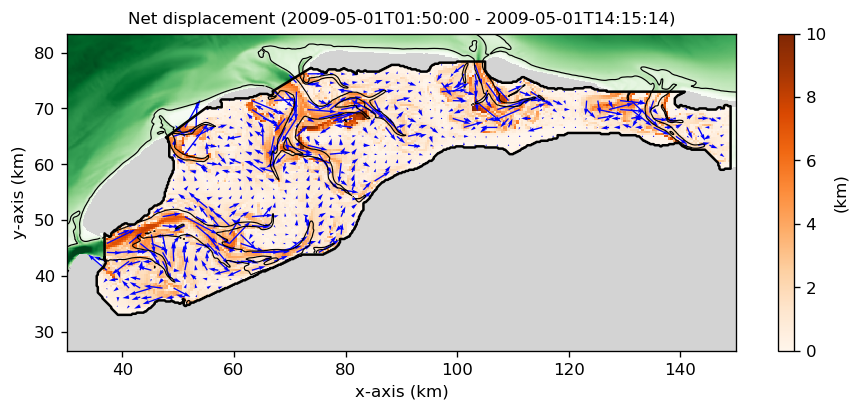

In [13]:
#gridded fields----
#module of net displacement = (dxx**2+dyy**2)**.5--
val=(dxx.isel(obs=it).values**2+dyy.isel(obs=0).values**2)**.5
xgrid,ygrid,ddgrid=gridding(val,x0,y0)
#net displacement vector--
val=dxx.isel(obs=it).values; _,_,dxgrid=gridding(val,x0,y0)
val=dyy.isel(obs=it).values; _,_,dygrid=gridding(val,x0,y0)
#
fig,ax=plt.subplots(1,1,figsize=(9,3.5),dpi=120)
#background map
cmap = mpl.cm.get_cmap("Greens").copy()
cmap.set_bad(color='lightgrey')
aa=ax.pcolormesh(xc/1e3,yc/1e3,h,vmin=-2,vmax=30,shading='auto',cmap=cmap)
ax.set_xlabel('x-axis (km)'); ax.set_ylabel('y-axis (km)')
ax.plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'-k',lw=1.5)
ax.contour(xc/1e3,yc/1e3,h,[5],colors='k',linewidths=.7)
#
aa=ax.pcolormesh(xgrid/1e3,ygrid/1e3,ddgrid,vmin=0,vmax=10,shading='auto',cmap="Oranges")#wind-energy lon-lat
cbar=plt.colorbar(aa,ax=ax); cbar.ax.set_ylabel("(km)")
#
iyy=4;ixx=5
vlim=6
dxgrid[abs(dxgrid)>vlim]=np.nan; dygrid[abs(dygrid)>vlim]=np.nan
Q = ax.quiver(xgrid[::iyy,::ixx]/1e3,ygrid[::iyy,::ixx]/1e3,dxgrid[::iyy,::ixx],dygrid[::iyy,::ixx],units='width',width=0.002,color='b')
#qk = ax.quiverkey(Q, 0.7, 0.4, 5, '5km', labelpos='S',coordinates='figure')
#
ax.axis('equal');ax.axis([30,150,30,80]);
ax.set_title(f'Net displacement ({t0} - {t1})',fontsize=10);

In [59]:
#for the 2nd deployment select the 1st displacement----

dep=1 #2nd deployment
it=0 #1st displacement
#
#net displacement
dxx=dst.x.isel(traj=np.arange(npa_per_dep)+npa_per_dep*dep,obs=range(10)).diff("obs")/1e3
dyy=dst.y.isel(traj=np.arange(npa_per_dep)+npa_per_dep*dep,obs=range(10)).diff("obs")/1e3
#
#initial time of the above deployment, and next time
t0=str(dst.time.isel(obs=0+it,traj=npa_per_dep*dep).values)[:-10]
t1=str(dst.time.isel(obs=0+it+1,traj=npa_per_dep*dep).values)[:-10]

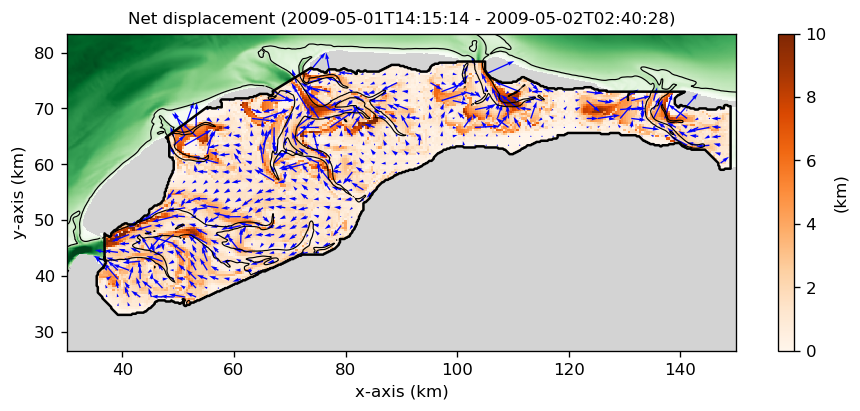

In [60]:
#gridded fields----
#module of net displacement = (dxx**2+dyy**2)**.5--
val=(dxx.isel(obs=it).values**2+dyy.isel(obs=it).values**2)**.5
xgrid,ygrid,ddgrid=gridding(val,x0,y0)
#net displacement vector--
val=dxx.isel(obs=it).values; _,_,dxgrid=gridding(val,x0,y0)
val=dyy.isel(obs=it).values; _,_,dygrid=gridding(val,x0,y0)
#
fig,ax=plt.subplots(1,1,figsize=(9,3.5),dpi=120)
#background map
cmap = mpl.cm.get_cmap("Greens").copy()
cmap.set_bad(color='lightgrey')
aa=ax.pcolormesh(xc/1e3,yc/1e3,h,vmin=-2,vmax=30,shading='auto',cmap=cmap)
ax.set_xlabel('x-axis (km)'); ax.set_ylabel('y-axis (km)')
ax.plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'-k',lw=1.5)
ax.contour(xc/1e3,yc/1e3,h,[5],colors='k',linewidths=.7)
#
aa=ax.pcolormesh(xgrid/1e3,ygrid/1e3,ddgrid,vmin=0,vmax=10,shading='auto',cmap="Oranges")#wind-energy lon-lat
cbar=plt.colorbar(aa,ax=ax); cbar.ax.set_ylabel("(km)")
#
iyy=4;ixx=5
vlim=6
dxgrid[abs(dxgrid)>vlim]=np.nan; dygrid[abs(dygrid)>vlim]=np.nan
Q = ax.quiver(xgrid[::iyy,::ixx]/1e3,ygrid[::iyy,::ixx]/1e3,dxgrid[::iyy,::ixx],dygrid[::iyy,::ixx],units='width',width=0.002,color='b')
#qk = ax.quiverkey(Q, 0.7, 0.4, 5, '5km', labelpos='S',coordinates='figure')
#
ax.axis('equal');ax.axis([30,150,30,80]);
ax.set_title(f'Net displacement ({t0} - {t1})',fontsize=10);

In [64]:
%%time
# save the 1st displacements for all the deployments of this month-------
#
#ini_dep / end_dep = 0(1st set of dep), 1(2nd set of dep), 2...
#it = 0(displacement after M2 from fixed grid ini positions), 1(displacement after 2xM2), ...2
ini_dep=0 #select index of initial deployment
end_dep=num_deploys_1m-1 #select index of last deployment
it=0 #select 1st displacement for all deployments
#
deploys=np.arange(npa_per_dep*ini_dep,npa_per_dep*(end_dep+1))
#
#net displacement from intial time of realese until the it time
#new
dxx=(dst.x.isel(traj=deploys,obs=[0,it+1]).diff("obs")/1e3).isel(obs=0)
dyy=(dst.y.isel(traj=deploys,obs=[0,it+1]).diff("obs")/1e3).isel(obs=0)
#
#gridded fields----
#module of net displacement = (dxx**2+dyy**2)**.5--
val_dxx,val_dyy=da.compute(dxx.values,dyy.values)
#val=(val_dxx**2+val_dyy**2)**.5
#
dx_grid=[];dy_grid=[];val_grid=[];tini=[];tend=[]
for i in range(end_dep-ini_dep+1):
    #xgrid,ygrid,valgrid=gridding(val[npa_per_dep*i:npa_per_dep*(i+1)],x0,y0)
    xgrid,ygrid,dxgrid=gridding2(val_dxx[npa_per_dep*i:npa_per_dep*(i+1)],x0,y0)
    _,_,dygrid=gridding2(val_dyy[npa_per_dep*i:npa_per_dep*(i+1)],x0,y0)
    dx_grid.append(dxgrid);dy_grid.append(dygrid)#;val_grid.append(valgrid)
dx_grid=np.array(dx_grid);dy_grid=np.array(dy_grid)#;val_grid=np.array(val_grid)
val_grid=(dx_grid**2+dy_grid**2)**.5
nt,ny,nx=dx_grid.shape
#
#initial time of the above deployment, and next time
t0=dst.time.isel(obs=0,traj=np.arange(ini_dep,end_dep+1)*npa_per_dep).values
t1=dst.time.isel(obs=it+1,traj=np.arange(ini_dep,end_dep+1)*npa_per_dep).values
#
#convert to xarray
#del dsout

dsout = xr.Dataset()
#global coords and attrs---
dsout.coords["time"] = t0
dsout["time"].attrs['description'] = 'initial date of deployments, values every M2'
dsout.coords["y"] = ygrid[:,0]
dsout["y"].attrs['description'] = 'y-position in meter'
dsout.coords["x"] = xgrid[0,:]
dsout["x"].attrs['description'] = 'x-position in meter'
#
dsout.attrs["year_month_of_deployments"] = f"{year_sim}-{month_sim:02d}"
dsout.attrs["npar"] = f"number of particles per deployment = {npa_per_dep}"
#
#variables---
#
dsout["it"] = it+1
dsout["it"].attrs['long_name'] = 'displacement betwenn [t0, t0+it*M2]'
dsout["m2"] = m2
dsout["m2"].attrs['long_name'] = 'm2 tidal period in seconds'
#
dsout["dx"] = (("time","y","x"),dx_grid)
dsout["dx"].attrs['long_name'] = 'displacement along x-axis'
#dsout["dx"].attrs['description'] = 'rt computed with the first crossing. NaN for stuck particles'
dsout["dx"].attrs['units'] = 'm'
#
dsout["dy"] = (("time","y","x"),dy_grid)
dsout["dy"].attrs['long_name'] = 'displacement along y-axis'
#dsout["dy"].attrs['description'] = 'rt computed with the first crossing. NaN for stuck particles'
dsout["dy"].attrs['units'] = 'm'
#
file_out_nc=f"{year_sim}{month_sim:02d}_net_displacement_during_{it+1}M2.nc"
dir_out_nc="post_proc_data/"
#dsout.to_netcdf(dir_out_nc+file_out_nc)
#dsout.close(); del dsout

CPU times: user 9.73 s, sys: 4.11 s, total: 13.8 s
Wall time: 9.06 s


In [77]:
%%time
#build grid (like the one of displacements)
xmin=x0.min();xmax=x0.max();ymin=y0.min();ymax=y0.max()
extend_grid=10 #so from particle min max positions extend grid 10*dx (to not have problems with convolution)
xgrid=np.arange(xmin-dx*1e3*extend_grid,xmax+dx*1e3*(extend_grid+1),dx*1e3)
ygrid=np.arange(ymin-dy*1e3*extend_grid,ymax+dy*1e3*(extend_grid+1),dy*1e3)
xgrid0,ygrid0=np.meshgrid(xgrid,ygrid)
#
#grid data with nearest----
ntt=int(len(dxx)/npa_per_dep)
dxxg=np.reshape(dxx.values,(ntt,npa_per_dep)) #(deploys,npa_per_dep)
dyyg=np.reshape(dyy.values,(ntt,npa_per_dep))
points=np.array([x0,y0]).T
dxxg = np.moveaxis(griddata(points, dxxg.T, (xgrid0, ygrid0), method='nearest'),-1,0)
dyyg= np.moveaxis(griddata(points, dyyg.T, (xgrid0, ygrid0), method='nearest'),-1,0)
#is faster than our gridding and the same results
np.sum(np.isnan(dxxg)),np.sum(np.isnan(dyyg)),np.nansum(dxxg-dx_grid),np.nansum(dyyg-dy_grid)
#now put nan ot the values that grid data put to the regions out DWS domain due to the nearest method
_,_,mask_par=gridding2(dxx[range(npa_per_dep)].values,x0,y0)
mask_par[np.isfinite(mask_par)]=1
dxxg*=mask_par; dyyg*=mask_par

CPU times: user 476 ms, sys: 388 ms, total: 864 ms
Wall time: 692 ms


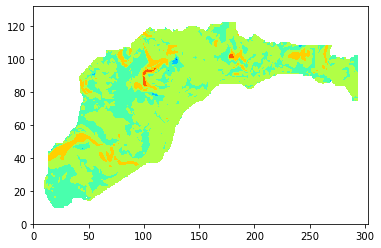

In [81]:
#check above
plt.contourf(dxxg[0,...],cmap='jet')

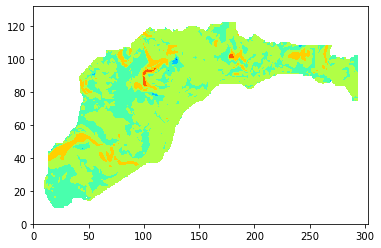

In [82]:
plt.contourf(dx_grid[0,...],cmap='jet')

### Net displacement every M2 for 2009-11

In [14]:
year_sim=2009; month_sim=11

#open particle trajectories---
file_track=f'tracks_{year_sim}{month_sim:02d}_coords-xcyc_save-{savee}_deploy-{deploy}_Tsim-{minTsim}-{maxTsim}d.nc'
file_track_path=f'{dir_tracks}{year_sim}/{file_track}'  
dst=xr.open_dataset(file_track_path, chunks={'traj': npa_per_dep}) #float32, a bit faster than npa_per_dep*10 when .compute data for this case
dst.close()
#get number of deployments for this month
num_deploys_1m=int(dict(dst.dims)['traj']/npa_per_dep)

#for the 28th deployment select the 1st displacement 
dep=33 #28th deployment
it=0 #1st displacement
#
#net displacement
dxx=dst.x.isel(traj=np.arange(npa_per_dep)+npa_per_dep*dep,obs=range(10)).diff("obs")/1e3
dyy=dst.y.isel(traj=np.arange(npa_per_dep)+npa_per_dep*dep,obs=range(10)).diff("obs")/1e3
#
#initial time of the above deployment, and next time
t0=str(dst.time.isel(obs=0+it,traj=npa_per_dep*dep).values)[:-10]
t1=str(dst.time.isel(obs=0+it+1,traj=npa_per_dep*dep).values)[:-10]

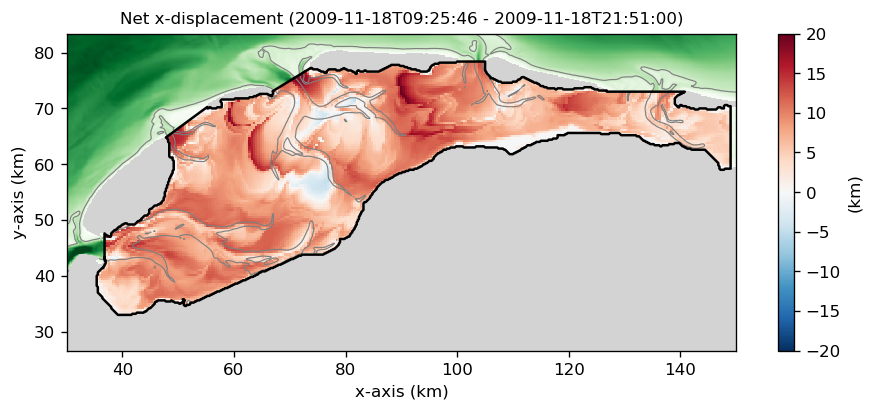

In [233]:
#dxx-----
val=dxx.isel(obs=it).values 
#
fig,ax=plt.subplots(1,1,figsize=(9,3.5),dpi=120)
#background map
cmap = mpl.cm.get_cmap("Greens").copy()
cmap.set_bad(color='lightgrey')
aa=ax.pcolormesh(xc/1e3,yc/1e3,h,vmin=-2,vmax=30,shading='auto',cmap=cmap)#wind-energy lon-lat
ax.set_xlabel('x-axis (km)'); ax.set_ylabel('y-axis (km)')
ax.plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'-k',lw=1.5)
ax.contour(xc/1e3,yc/1e3,h,[5],colors='grey',linewidths=.7)
pc = PolyCollection(polys0,cmap='RdBu_r') 
val = np.ma.array(val, mask=np.isnan(val)) #mask because array idtrmout has nan values
pc.set_array(val);pc.set_clim([-20,20])
ax.add_collection(pc); cbar=plt.colorbar(pc,ax=ax); cbar.ax.set_ylabel("(km)")
ax.plot()
ax.axis('equal');ax.axis([30,150,30,80]);
ax.set_title(f'Net x-displacement ({t0} - {t1})',fontsize=10);

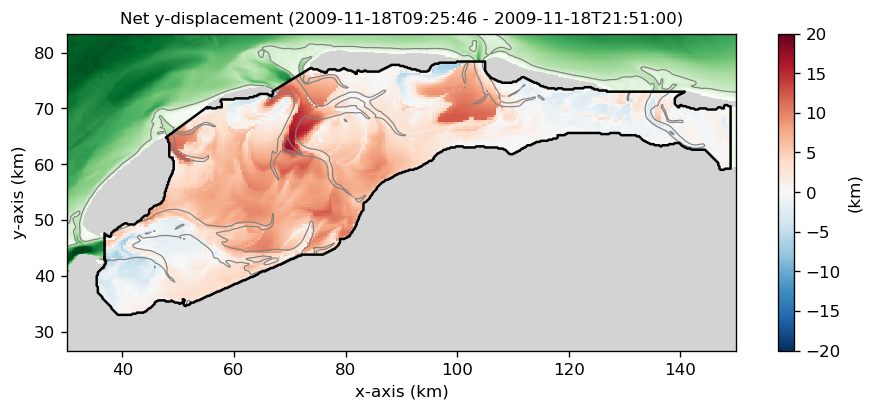

In [234]:
#dxx-----
val=dyy.isel(obs=it).values 
#
fig,ax=plt.subplots(1,1,figsize=(9,3.5),dpi=120)
#background map
cmap = mpl.cm.get_cmap("Greens").copy()
cmap.set_bad(color='lightgrey')
aa=ax.pcolormesh(xc/1e3,yc/1e3,h,vmin=-2,vmax=30,shading='auto',cmap=cmap)#wind-energy lon-lat
ax.set_xlabel('x-axis (km)'); ax.set_ylabel('y-axis (km)')
ax.plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'-k',lw=1.5)
ax.contour(xc/1e3,yc/1e3,h,[5],colors='grey',linewidths=.7)
pc = PolyCollection(polys0,cmap='RdBu_r') 
val = np.ma.array(val, mask=np.isnan(val)) #mask because array idtrmout has nan values
pc.set_array(val);pc.set_clim([-20,20])
ax.add_collection(pc); cbar=plt.colorbar(pc,ax=ax); cbar.ax.set_ylabel("(km)")
ax.plot()
ax.axis('equal');ax.axis([30,150,30,80]);
ax.set_title(f'Net y-displacement ({t0} - {t1})',fontsize=10);

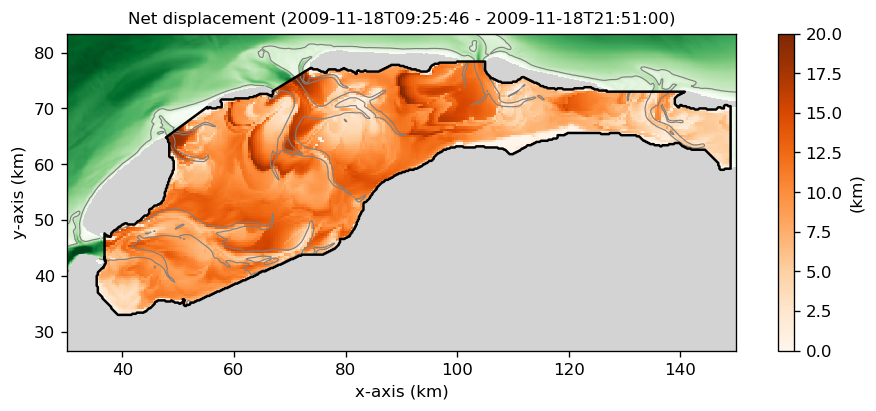

In [238]:
#(dxx**2+dyy**2)**.5-----
it=0 #first y-displacement
val=(dxx.isel(obs=it).values**2+dyy.isel(obs=it).values**2)**.5
#
fig,ax=plt.subplots(1,1,figsize=(9,3.5),dpi=120)
#background map
cmap = mpl.cm.get_cmap("Greens").copy()
cmap.set_bad(color='lightgrey')
aa=ax.pcolormesh(xc/1e3,yc/1e3,h,vmin=-2,vmax=30,shading='auto',cmap=cmap)#wind-energy lon-lat
ax.set_xlabel('x-axis (km)'); ax.set_ylabel('y-axis (km)')
ax.plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'-k',lw=1.5)
ax.contour(xc/1e3,yc/1e3,h,[5],colors='grey',linewidths=.7)
pc = PolyCollection(polys0,cmap='Oranges') 
val = np.ma.array(val, mask=np.isnan(val)) #mask because array idtrmout has nan values
pc.set_array(val);pc.set_clim([0,20])
ax.add_collection(pc); cbar=plt.colorbar(pc,ax=ax); cbar.ax.set_ylabel("(km)")
ax.plot()
ax.axis('equal');ax.axis([30,150,30,80]);
ax.set_title(f'Net displacement ({t0} - {t1})',fontsize=10);

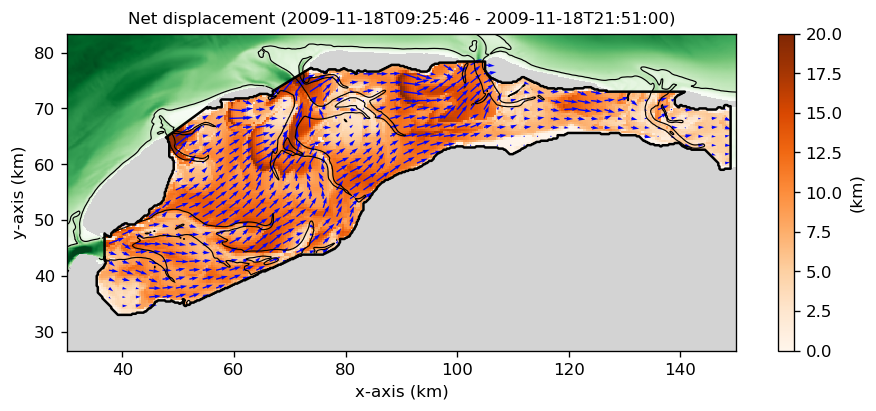

In [278]:
#gridded fields----
#module of net displacement = (dxx**2+dyy**2)**.5--
val=(dxx.isel(obs=it).values**2+dyy.isel(obs=it).values**2)**.5
xgrid,ygrid,ddgrid=gridding(val,x0,y0)
#net displacement vector--
val=dxx.isel(obs=it).values; _,_,dxgrid=gridding(val,x0,y0)
val=dyy.isel(obs=it).values; _,_,dygrid=gridding(val,x0,y0)
#
fig,ax=plt.subplots(1,1,figsize=(9,3.5),dpi=120)
#background map
cmap = mpl.cm.get_cmap("Greens").copy()
cmap.set_bad(color='lightgrey')
aa=ax.pcolormesh(xc/1e3,yc/1e3,h,vmin=-2,vmax=30,shading='auto',cmap=cmap)
ax.set_xlabel('x-axis (km)'); ax.set_ylabel('y-axis (km)')
ax.plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'-k',lw=1.5)
ax.contour(xc/1e3,yc/1e3,h,[5],colors='k',linewidths=.7)
#
aa=ax.pcolormesh(xgrid/1e3,ygrid/1e3,ddgrid,vmin=0,vmax=20,shading='auto',cmap="Oranges")#wind-energy lon-lat
cbar=plt.colorbar(aa,ax=ax); cbar.ax.set_ylabel("(km)")
#
iyy=4;ixx=6
Q = ax.quiver(xgrid[::iyy,::ixx]/1e3,ygrid[::iyy,::ixx]/1e3,dxgrid[::iyy,::ixx],dygrid[::iyy,::ixx],units='width',width=0.002,color='b')
#qk = ax.quiverkey(Q, 0.7, 0.4, 20, '20km', labelpos='S',coordinates='figure')
#
ax.axis('equal');ax.axis([30,150,30,80]);
ax.set_title(f'Net displacement ({t0} - {t1})',fontsize=10);

In [287]:
#for the 29th deployment select the 1st displacement---

dep=34 #29th deployment
it=0 #1st displacement
#
#net displacement
dxx=dst.x.isel(traj=np.arange(npa_per_dep)+npa_per_dep*dep,obs=range(10)).diff("obs")/1e3
dyy=dst.y.isel(traj=np.arange(npa_per_dep)+npa_per_dep*dep,obs=range(10)).diff("obs")/1e3
#
#initial time of the above deployment, and next time
t0=str(dst.time.isel(obs=0+it,traj=npa_per_dep*dep).values)[:-10]
t1=str(dst.time.isel(obs=0+it+1,traj=npa_per_dep*dep).values)[:-10]

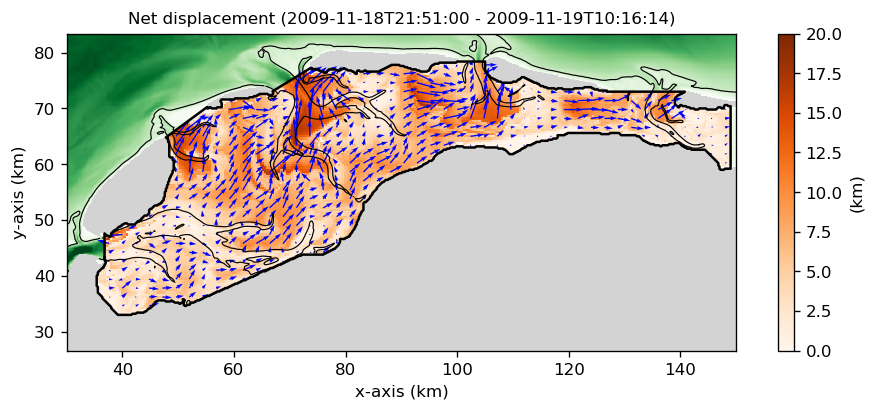

In [288]:
#gridded fields----
#module of net displacement = (dxx**2+dyy**2)**.5--
val=(dxx.isel(obs=it).values**2+dyy.isel(obs=it).values**2)**.5
xgrid,ygrid,ddgrid=gridding(val,x0,y0)
#net displacement vector--
val=dxx.isel(obs=it).values; _,_,dxgrid=gridding(val,x0,y0)
val=dyy.isel(obs=it).values; _,_,dygrid=gridding(val,x0,y0)
#
fig,ax=plt.subplots(1,1,figsize=(9,3.5),dpi=120)
#background map
cmap = mpl.cm.get_cmap("Greens").copy()
cmap.set_bad(color='lightgrey')
aa=ax.pcolormesh(xc/1e3,yc/1e3,h,vmin=-2,vmax=30,shading='auto',cmap=cmap)
ax.set_xlabel('x-axis (km)'); ax.set_ylabel('y-axis (km)')
ax.plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'-k',lw=1.5)
ax.contour(xc/1e3,yc/1e3,h,[5],colors='k',linewidths=.7)
#
aa=ax.pcolormesh(xgrid/1e3,ygrid/1e3,ddgrid,vmin=0,vmax=20,shading='auto',cmap="Oranges")#wind-energy lon-lat
cbar=plt.colorbar(aa,ax=ax); cbar.ax.set_ylabel("(km)")
#
iyy=4;ixx=6
Q = ax.quiver(xgrid[::iyy,::ixx]/1e3,ygrid[::iyy,::ixx]/1e3,dxgrid[::iyy,::ixx],dygrid[::iyy,::ixx],units='width',width=0.002,color='b')
#qk = ax.quiverkey(Q, 0.7, 0.4, 20, '20km', labelpos='S',coordinates='figure')
#
ax.axis('equal');ax.axis([30,150,30,80]);
ax.set_title(f'Net displacement ({t0} - {t1})',fontsize=10);

In [15]:
# save the 1st displacements for all the deployments of this month-------
#
#ini_dep / end_dep = 0(1st dep), 1(2nd dep), 2...
#it = 0(displacement after M2 from fixed grid ini positions), 1(displacement after 2xM2), ...2
ini_dep=0 #select index of initial deployment
end_dep=num_deploys_1m-1 #select index of last deployment
it=0 #select 1st displacement for all deployments
#
deploys=np.arange(npa_per_dep*ini_dep,npa_per_dep*(end_dep+1))
#
#net displacement from intial time of realese until the it time
#new
dxx=(dst.x.isel(traj=deploys,obs=[0,it+1]).diff("obs")/1e3).isel(obs=0)
dyy=(dst.y.isel(traj=deploys,obs=[0,it+1]).diff("obs")/1e3).isel(obs=0)
#
#gridded fields----
#module of net displacement = (dxx**2+dyy**2)**.5--
val_dxx,val_dyy=da.compute(dxx.values,dyy.values)
#val=(val_dxx**2+val_dyy**2)**.5
#
dx_grid=[];dy_grid=[];val_grid=[];tini=[];tend=[]
for i in range(end_dep-ini_dep+1):
    #xgrid,ygrid,valgrid=gridding(val[npa_per_dep*i:npa_per_dep*(i+1)],x0,y0)
    xgrid,ygrid,dxgrid=gridding2(val_dxx[npa_per_dep*i:npa_per_dep*(i+1)],x0,y0)
    _,_,dygrid=gridding2(val_dyy[npa_per_dep*i:npa_per_dep*(i+1)],x0,y0)
    dx_grid.append(dxgrid);dy_grid.append(dygrid)#;val_grid.append(valgrid)
dx_grid=np.array(dx_grid);dy_grid=np.array(dy_grid)#;val_grid=np.array(val_grid)
val_grid=(dx_grid**2+dy_grid**2)**.5
nt,ny,nx=dx_grid.shape
#
#initial time of the above deployment, and next time
t0=dst.time.isel(obs=0,traj=np.arange(ini_dep,end_dep+1)*npa_per_dep).values
t1=dst.time.isel(obs=it+1,traj=np.arange(ini_dep,end_dep+1)*npa_per_dep).values
#
#convert to xarray
dsout.close()
del dsout
#
dsout = xr.Dataset()
#global coords and attrs---
dsout.coords["time"] = t0
dsout["time"].attrs['description'] = 'initial date of deployments, values every M2'
dsout.coords["y"] = ygrid[:,0]
dsout["y"].attrs['description'] = 'y-position in meter'
dsout.coords["x"] = xgrid[0,:]
dsout["x"].attrs['description'] = 'x-position in meter'
#
dsout.attrs["year_month_of_deployments"] = f"{year_sim}-{month_sim:02d}"
dsout.attrs["npar"] = f"number of particles per deployment = {npa_per_dep}"
#
#variables---
#
dsout["it"] = it+1
dsout["it"].attrs['long_name'] = 'displacement betwenn [t0, t0+it*M2]'
dsout["m2"] = m2
dsout["m2"].attrs['long_name'] = 'm2 tidal period in seconds'
#
dsout["dx"] = (("time","y","x"),dx_grid)
dsout["dx"].attrs['long_name'] = 'displacement along x-axis'
#dsout["dx"].attrs['description'] = 'rt computed with the first crossing. NaN for stuck particles'
dsout["dx"].attrs['units'] = 'm'
#
dsout["dy"] = (("time","y","x"),dy_grid)
dsout["dy"].attrs['long_name'] = 'displacement along y-axis'
#dsout["dy"].attrs['description'] = 'rt computed with the first crossing. NaN for stuck particles'
dsout["dy"].attrs['units'] = 'm'
#
file_out_nc=f"{year_sim}{month_sim:02d}_net_displacement_during_{it+1}M2.nc"
dir_out_nc="post_proc_data/"
#dsout.to_netcdf(dir_out_nc+file_out_nc)
#dsout.close(); del dsout

### Compute all the displacementes for a particular year

In [13]:
#gridding data with nearest neighbor in a extended domain (to avoid problems in boundaries when using convolution)
def gridding_particles(var,x0,y0):
    xmin=x0.min();xmax=x0.max();ymin=y0.min();ymax=y0.max()
    extend_grid=10 #so from particle min max positions extend grid 10*dx (to not have problems with convolution)
    xgrid=np.arange(xmin-dx*1e3*extend_grid,xmax+dx*1e3*(extend_grid+1),dx*1e3)
    ygrid=np.arange(ymin-dy*1e3*extend_grid,ymax+dy*1e3*(extend_grid+1),dy*1e3)
    xgrid0,ygrid0=np.meshgrid(xgrid,ygrid)
    valgrid=xgrid0.flatten()*np.nan
    tree = cKDTree(np.c_[xgrid0.flatten(),ygrid0.flatten()]) #points in the new extended grid
    _,ij = tree.query(np.c_[x0,y0], k=1) #get index for every x0,y0 to put values in the new grid
    valgrid[ij]=var
    valgrid=np.reshape(valgrid,(len(ygrid),len(xgrid)))
    return xgrid0,ygrid0,valgrid

In [28]:
%%time

year="2009"
files_track_paths=sorted(glob.glob(f'{dir_tracks}{year}/*.nc',recursive=True)) 

dx_grid=[]; dy_grid=[]
for i in range(len(files_track_paths)):
    #
    print(files_track_paths[i][-68:])
    dst0=xr.open_dataset(files_track_paths[i], chunks={'traj': npa_per_dep}) #float32, a bit faster than npa_per_dep*10 when .compute data for this case
    dst0.close()
    #
    #get number of deployments for this month
    num_deploys_1m0=int(dict(dst0.dims)['traj']/npa_per_dep)
    #ini_dep / end_dep = 0(1st dep), 1(2nd dep), 2...
    #it = 0(displacement after M2 from fixed grid ini positions), 1(displacement after 2xM2), ...2
    ini_dep=0 #select index of initial deployment
    end_dep=num_deploys_1m0-1 #select index of last deployment
    it=0 #select 1st displacement for all deployments
    #
    if i==0:
        #build grid (like the one of displacements)
        x0=dst0.x.isel(traj=range(npa_per_dep),obs=0).values; y0=dst0.y.isel(traj=range(npa_per_dep),obs=0)
        xmin=x0.min();xmax=x0.max();ymin=y0.min();ymax=y0.max()
        extend_grid=10 #so from particle min max positions extend grid 10*dx (to not have problems with convolution)
        xgrid=np.arange(xmin-dx*1e3*extend_grid,xmax+dx*1e3*(extend_grid+1),dx*1e3c
        ygrid=np.arange(ymin-dy*1e3*extend_grid,ymax+dy*1e3*(extend_grid+1),dy*1e3,dtype='float32')
        xgrid0,ygrid0=np.meshgrid(xgrid,ygrid)
        points=np.array([x0,y0]).T
        tdep_ini=dst0.time.isel(obs=0,traj=ini_dep*npa_per_dep).values #initial date of deployment for this year
    if i==len(files_track_paths)-1:
        tdep_end=dst0.time.isel(obs=0,traj=(end_dep+1)*npa_per_dep-1).values #final date of deployment for this year
    #
    # save the 1st displacements for all the deployments of this month-------
    deploys=np.arange(npa_per_dep*ini_dep,npa_per_dep*(end_dep+1))  
    #net displacement from intial time of realese until the it time
    dxx=(dst0.x.isel(traj=deploys,obs=[0,it+1]).diff("obs")/1e3).isel(obs=0)
    dyy=(dst0.y.isel(traj=deploys,obs=[0,it+1]).diff("obs")/1e3).isel(obs=0)
    #
    #grid data with nearest----
    #it is faster than our gridding method and the same results 
    ntt=int(len(dxx)/npa_per_dep)
    dx_grid0=np.reshape(dxx.values,(ntt,npa_per_dep)) #(deploys,npa_per_dep)
    dx_grid0 = np.moveaxis(griddata(points, dx_grid0.T, (xgrid0, ygrid0), method='nearest'),-1,0)
    dy_grid0=np.reshape(dyy.values,(ntt,npa_per_dep))
    dy_grid0= np.moveaxis(griddata(points, dy_grid0.T, (xgrid0, ygrid0), method='nearest'),-1,0)
    print(np.sum(np.isnan(dx_grid0)),np.sum(np.isnan(dy_grid0)))
    #now put nan ot the values that grid data put to the regions out DWS domain due to the nearest method
    _,_,mask_par=gridding_particles(dxx[range(npa_per_dep)].values,x0,y0)
    mask_par[np.isfinite(mask_par)]=1
    dx_grid0*=mask_par; dy_grid0*=mask_par
    #initial time of the above deployment, and next time
    #t0=dst0.time.isel(obs=0,traj=np.arange(ini_dep,end_dep+1)*npa_per_dep).values
    #t1=dst0.time.isel(obs=it+1,traj=np.arange(ini_dep,end_dep+1)*npa_per_dep).values
    #
    #save data
    dx_grid.append(dx_grid0); dy_grid.append(dy_grid0)

    
#Saving all the months in 1 file for this year-----
#
t_dep=np.arange(tdep_ini,tdep_end+np.timedelta64(1,'s'),m2,dtype='datetime64[s]') #only for this year
dx_grid=np.concatenate(dx_grid,axis=0) #(time_dep,y,x)
dy_grid=np.concatenate(dy_grid,axis=0)

dsout = xr.Dataset()
#global coords and attrs---
dsout.coords["time"] = t_dep
dsout["time"].attrs['description'] = 'initial date of deployments, values every M2'
dsout.coords["y"] = ygrid
dsout["y"].attrs['description'] = 'y-position in meter'
dsout.coords["x"] = xgrid
dsout["x"].attrs['description'] = 'x-position in meter'
#
dsout.attrs["year_of_deployments"] = f"{year}"
dsout.attrs["npar"] = f"number of particles per deployment = {npa_per_dep}"
#
#variables---
#
dsout["it"] = it+1
dsout["it"].attrs['long_name'] = 'net displacement between [t0, t0+it*M2]'
dsout["m2"] = m2
dsout["m2"].attrs['long_name'] = 'm2 tidal period in seconds'
#
dsout["dx"] = (("time","y","x"),dx_grid)
dsout["dx"].attrs['long_name'] = 'net displacement along x-axis'
#dsout["dx"].attrs['description'] = 'rt computed with the first crossing. NaN for stuck particles'
dsout["dx"].attrs['units'] = 'm'
#
dsout["dy"] = (("time","y","x"),dy_grid)
dsout["dy"].attrs['long_name'] = 'net displacement along y-axis'
#dsout["dy"].attrs['description'] = 'rt computed with the first crossing. NaN for stuck particles'
dsout["dy"].attrs['units'] = 'm'
#
file_out_nc=f"{year}_net_displacement_during_{it+1}M2.nc"
dir_out_nc=f"post_proc_data/net_displacement/"
dsout.to_netcdf(dir_out_nc+file_out_nc)
dsout.close()
del dsout
    
    
#OLD, for saving a file per month-----
# dsout = xr.Dataset()
# #global coords and attrs---
# dsout.coords["time"] = t0
# dsout["time"].attrs['description'] = 'initial date of deployments, values every M2'
# dsout.coords["y"] = ygrid
# dsout["y"].attrs['description'] = 'y-position in meter'
# dsout.coords["x"] = xgrid
# dsout["x"].attrs['description'] = 'x-position in meter'
# #
# dsout.attrs["year_month_of_deployments"] = f"{year}-{i+1:02d}"
# dsout.attrs["npar"] = f"number of particles per deployment = {npa_per_dep}"
# #
# #variables---
# #
# dsout["it"] = it+1
# dsout["it"].attrs['long_name'] = 'net displacement between [t0, t0+it*M2]'
# dsout["m2"] = m2
# dsout["m2"].attrs['long_name'] = 'm2 tidal period in seconds'
# #
# dsout["dx"] = (("time","y","x"),dx_grid0)
# dsout["dx"].attrs['long_name'] = 'net displacement along x-axis'
# #dsout["dx"].attrs['description'] = 'rt computed with the first crossing. NaN for stuck particles'
# dsout["dx"].attrs['units'] = 'm'
# #
# dsout["dy"] = (("time","y","x"),dy_grid0)
# dsout["dy"].attrs['long_name'] = 'net displacement along y-axis'
# #dsout["dy"].attrs['description'] = 'rt computed with the first crossing. NaN for stuck particles'
# dsout["dy"].attrs['units'] = 'm'
# #
# file_out_nc=f"{year}{i+1:02d}_net_displacement_during_{it+1}M2.nc"
# dir_out_nc=f"post_proc_data/{year}/net_displacement/"
# dsout.to_netcdf(dir_out_nc+file_out_nc)
# dsout.close()
# del dsout

tracks_200901_coords-xcyc_save-everyM2_deploy-everyM2_Tsim-60-91d.nc
0 0
tracks_200902_coords-xcyc_save-everyM2_deploy-everyM2_Tsim-60-91d.nc
0 0
tracks_200903_coords-xcyc_save-everyM2_deploy-everyM2_Tsim-60-91d.nc
0 0
tracks_200904_coords-xcyc_save-everyM2_deploy-everyM2_Tsim-60-91d.nc
0 0
tracks_200905_coords-xcyc_save-everyM2_deploy-everyM2_Tsim-60-91d.nc
0 0
tracks_200906_coords-xcyc_save-everyM2_deploy-everyM2_Tsim-60-91d.nc
0 0
tracks_200907_coords-xcyc_save-everyM2_deploy-everyM2_Tsim-60-91d.nc
0 0
tracks_200908_coords-xcyc_save-everyM2_deploy-everyM2_Tsim-60-91d.nc
0 0
tracks_200909_coords-xcyc_save-everyM2_deploy-everyM2_Tsim-60-91d.nc
0 0
tracks_200910_coords-xcyc_save-everyM2_deploy-everyM2_Tsim-60-91d.nc
0 0
tracks_200911_coords-xcyc_save-everyM2_deploy-everyM2_Tsim-60-91d.nc
0 0
tracks_200912_coords-xcyc_save-everyM2_deploy-everyM2_Tsim-60-91d.nc
0 0
CPU times: user 5.12 s, sys: 5.42 s, total: 10.5 s
Wall time: 8.54 s
